# ДПО ВШЭ

## Современный анализ данных, глубокое обучение и приложения

## Задание на тему: "Соревнования по анализу данных"

В этом задании мы будем решать соревнование по определению лояльности пользователей сети [Kaggle Elo Merchant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation).

Сначала мы будем действовать самостоятельно (загрузим данные, посмотрим на них, прикинем, что можно сделать, подготовим простое решение и сравним его с локальной валидацией). Далее перейдём к особенностям решения соревнований на платформе (изучение публичных решений и форума).

Для начала необходимо загрузить все данные и расположить их рядом с этим ноутбуком.

In [3]:
%pylab inline
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

# Displaying pd Dataframe options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Своё решение

### Загрузка данных

In [4]:
data_dir = 'elo-merchant-category-recommendation/'

In [5]:
df_train = pd.read_csv(data_dir + '/train.csv')
df_test = pd.read_csv(data_dir + '/test.csv')
df_hist_trans = pd.read_csv(data_dir + '/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv(data_dir + '/new_merchant_transactions.csv')

**Ответьте на вопросы:** (по 1-2 предложениям на вопрос)

1. Какая информация доступна нам?
1. Чем характеризуется лояльность покупателя? (по собственному опыту)
1. Какие признаки в первую очередь можно было бы построить на текущих данных?
1. Какая метрика у данной задачи?

**Ответы:**
1. Нам доступны:
    файлы train.csv и test.csv. Они содержат card_ids, которые мы будем использовать для обучения и прогнозирования.

    Файлы исторические_транзакции.csv и new_merchant_transactions.csv содержат информацию о транзакциях каждой карты.

    history_transactions.csv содержит транзакции на срок до 3 месяцев для каждой карты в любом из предоставленных merchant_ids.

    new_merchant_transactions.csv содержит транзакции у новых продавцов (merchant_ids, которые этот конкретный card_id еще не посещал) в течение двух месяцев.

    В merchants.csv содержится сводная информация для каждого merchant_id, представленного в наборе данных.

1. Частотой покупок и продолжительностью привязанности к сервису
1. Для каждолго покупателя можно сделать расчет на сонове истории его покупок: сумму всех покупок. Срденяя по покупкам.
1. Root Mean Squared Error (RMSE)



### Первичная аналитика

**Ответьте на следующие вопросы.** Для ответа вам необходимо произвести некоторую аналитику. К каждому ответу нужно оставить поясняющую ваш ответ иллюстрацию или краткое рассуждение.

1. Посмотрите распределение целевой переменной. Есть ли что-то интересное? Как это согласуется с метрикой в задаче?
1. Сравните обучающую и тестовую выборки. Как, во-вашему, разбиты данные на обучение и тест? Какую валидацию можно было бы использовать?

**Ответы:** ...

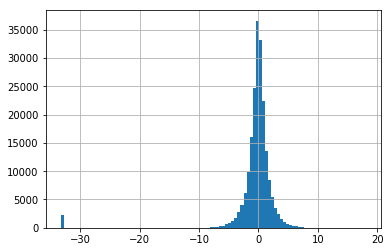

In [6]:
# Распределение целевой переменной - нормальное
# Есть выброс.
# RMSE – квадратичная функция. Следовательно чем больше мы ошибаемся, тем существенно больше штраф. 
# В отличае от MAE(линейной функции). Где ошибка пропорциональна штрафу.
# Вот это вот выброс слева на графике может испаганить нам всю картину.
# На то он и выброс.
df_train.target.hist(bins = 100)

In [7]:
train_dates = df_train['first_active_month'].astype('str').unique()

In [12]:
test_dates = df_test['first_active_month'].astype('str').unique()

In [13]:
test_dates = test_dates[test_dates != 'nan']

In [14]:
[train_dates.min(), train_dates.max()]

['2011-11', '2018-02']

In [15]:
[test_dates.min(), test_dates.max()]

['2011-11', '2018-01']

In [ ]:
# На первый взгляд данные теста и трейна схожи.
# Отличие по датам. Трейн захватывает промежуток по датам больше на месяц.

In [ ]:
# Кажется что для обучения нужно испольщовать метрику RMSE 
# Сначала я думал, что для валидации нужно использовать подход 
# описанный на занятии:
# Учу на половине, а, тестирую на остальном
# Потом в трейн добавляю 1 фолд, из теста его убираю
# и так далее. Но это сложно. Я такое не делал. Не знаю получится ли...

# Но так как дата здесь выполняет роль признака и здесь нет никакой историчности
# Можно, кажется, исопльзовать обычную валидацию

### Бейзлайн-решение

Готовить бейзлайн решение будем вместе с валидацией. Возьмём несколько исходных признаков (не забудьте про их типы!) и добавим несколько самых простых на основе других таблиц. Не забудем про даты и признаки на их основе. 

**Подготовьте около 10 признаков для обучающей и тестовой выборки**.

In [16]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [17]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [18]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [19]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

50

In [20]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [21]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,2,21,94,41,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,2018-02-25 09:31:15,2017-06-27 14:18:08,0,-8,-3.911538,5.748901,11.542308,247,0.950000,90,0.346154,0,0.000000,260,0.072502,0.346719,242,0.930769,348,2.0,8.0,7.0,7.0,1.0,10.0,23.0,14.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,2018-04-29 11:23:05,2018-03-05 14:04:36,2.0,1.0,1.478261,0.260870,11.521739,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,285.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,2,24,142,57,-210.006336,4.630299,-0.742400,-0.600018,0.148200,543,10,-1,1.551429,2.282448,2018-01-31 22:31:09,2017-01-06 16:29:42,0,-12,-5.031429,14.477519,12.462857,339,0.968571,132,0.377143,31,0.088571,350,0.074568,-0.295163,390,1.114286,372,2.0,5.0,4.0,4.0,1.0,4.0,6.0,5.0,-4.355735,-0.701858,-0.739410,-0.725956,0.000205,6.0,1.0,1.0,1.000000,0.000000,2018-03-30 06:48:26,2018-02-01 17:07:54,2.0,1.0,1.500000,0.300000,12.500000,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,315.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,2,7,13,8,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,0,0,0,0.000000,0.000000,2018-02-27 19:08:25,2017-01-11 08:21:22,0,-13,-8.604651,14.768549,11.325581,41,0.953488,11,0.255814,0,0.000000,43,-0.087803,0.358458,412,9.581395,345,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.0,0.0,0.000000,NaN,2018-04-28 17:43:11,2018-04-28 17:43:11,2.0,2.0,2.000000,NaN,11.000000,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,285.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,2,13,50,25,-49.491364,1.445596,-0.740897,-0.642745,0.068447,84,3,-1,1.090909,0.346890,2018-02-28 11:44:40,2017-09-26 16:22:21,0,-5,-2.831169,3.247437,11.415584,77,1.000000,11,0.142857,12,0.155844,77,-0.086166,-0.338321,154,2.000000,345,2.0,5.0,5.0,4.0,1.0,5.0,7.0,6.0,-4.654372,-0.566740,-0.734135,-0.664910,0.004340,5.0,1.0,-1.0,0.714286,0.571429,2018-04-18 11:00:11,2018-03-07 11:55:06,2.0,1.0,1.714286,0.238095,11.571429,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.8

In [22]:
# Тот самый выброс из трейна
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [23]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [24]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

**Попробуйте обучить модель и оценить качество локально** (возьмите тот тип валидации, который считаете нужным). Если ваш тип валидации подразумевает случайность, зафиксируйте параметры случайности.

Попробуйте и градиентный бустинг(lGBM), и гребневую регрессию(Ridge regression) из удобных вам библиотек.

In [25]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66626	valid_1's rmse: 3.72132
[200]	training's rmse: 3.59047	valid_1's rmse: 3.68837
[300]	training's rmse: 3.54496	valid_1's rmse: 3.6746
[400]	training's rmse: 3.50975	valid_1's rmse: 3.66775
[500]	training's rmse: 3.48037	valid_1's rmse: 3.66293
[600]	training's rmse: 3.45547	valid_1's rmse: 3.66009
[700]	training's rmse: 3.43323	valid_1's rmse: 3.65756
[800]	training's rmse: 3.41286	valid_1's rmse: 3.65623
[900]	training's rmse: 3.39451	valid_1's rmse: 3.65524
[1000]	training's rmse: 3.37665	valid_1's rmse: 3.65427
[1100]	training's rmse: 3.36101	valid_1's rmse: 3.6538
[1200]	training's rmse: 3.34518	valid_1's rmse: 3.65313
[1300]	training's rmse: 3.32964	valid_1's rmse: 3.65295
[1400]	training's rmse: 3.31464	valid_1's rmse: 3.65267
[1500]	training's rmse: 3.29967	valid_1's rmse: 3.65288
Early stopping, best iteration is:
[1491]	training's rmse: 3.30087	valid_1's rmse: 3.65262
fold 1
Tra

3.6527423290913683

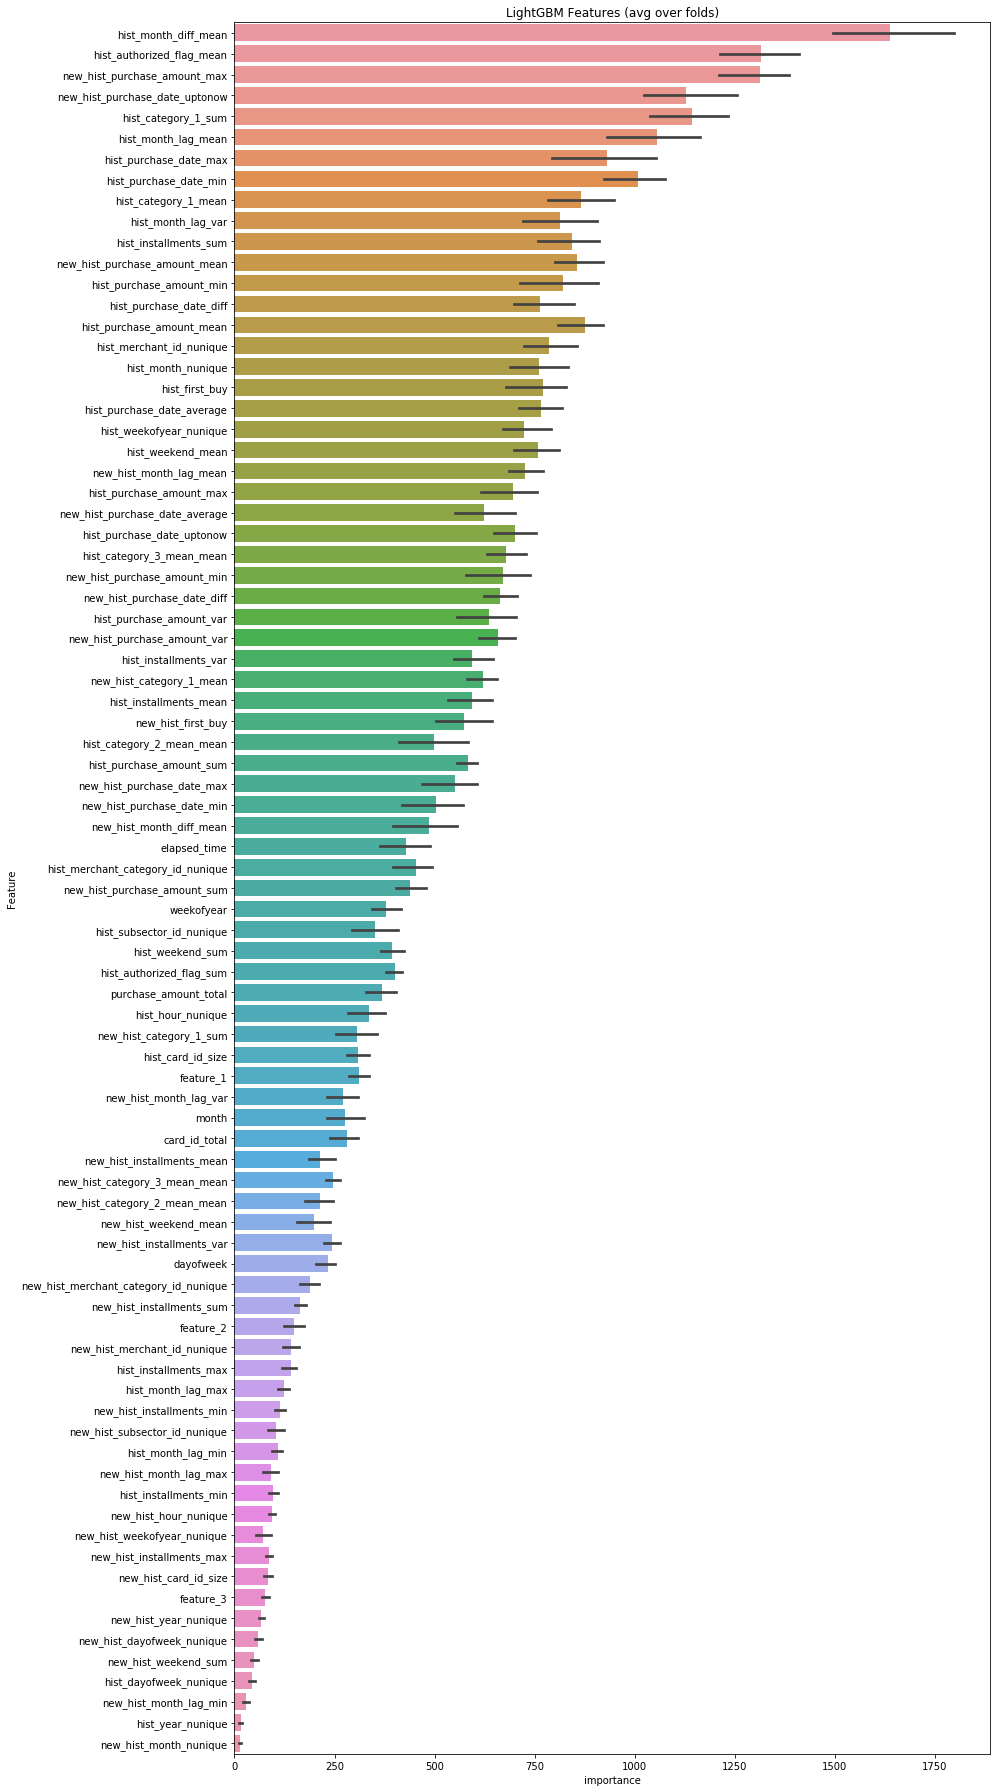

In [26]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

Проверить, что модель выучивает "что-то" можно, сравнив её с самым простым и тупым решением — константным предсказанием. Для простоты можно не делать это честно через используемый способ валидации.

**Ответьте:**
1. Какая константа будет оптимальной для нашего функционала? (Если не помните, то найдите минимум функции потерь через дифференцирование функции).
2. Как отличается качество у константного решения и двух обученных моделей?

**Ответы:**
1. C = (-0.5), RMSE = 3.8519592448737137
1. Бэйзлайн решение = 3.6527423290913683. Не сильно лучше :-(

In [47]:
for i in np.arange(-4.0, 4.0, 0.5):
    constanta = numpy.array([i for x in range(len(df_train))])
    get_rmse = np.sqrt(mean_squared_error(constanta, target))
    print(i, get_rmse)

-4.0 5.2756171137244365
-3.5 4.947299488579618
-3.0 4.649667571856953
-2.5 4.388968538034434
-2.0 4.172131484856884
-1.5 4.006284741005324
-1.0 3.8979422424004797
-0.5 3.8519592448737137
0.0 3.8705589161316296
0.5 3.9528296981180513
1.0 4.094935765235155
1.5 4.290936403686264
2.0 4.533847319833124
2.5 4.816576358642723
3.0 5.132547527077949
3.5 5.476009534030412


Обучите лучшую из моделей на всей обучающей выборке, сделайте предсказание на тестовой. Сохраните ваши предсказания и отправьте их на платформу. Какое качество получилось на лидерборде? Как это соотносится с локальным качеством?

**Ответы:**

In [48]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [49]:
!ls

elo-merchant-category-recommendation lgbm_importances.png
hse-ds-competition-task.ipynb        submission.csv


#### После сабмита на Кагле = 3.699 и локальная валидация = 3.652

Попробуйте немного изменить параметры модели или добавить новых признаков. Оцените локальное качество и сравните его с лидербордом. Что у вас получилось?

**Ответ:**

In [ ]:
# your code

Возможно, вы замечали что-то интересное при изучении распределения целевой переменной. Как это могло отразиться на вашем решении? Что с этим можно сделать?

**Ответы:**
Да этот выброс отработал выше. Присвоил ему значение 1.

In [ ]:
# your code

Метрика этой задачи допускает проверку среднего значения на тестовой части выборки. Попробуйте вычислить среднее значение на публичной части тестовой выборки (через 2 сабмита). 

Для простоты можно проверить (через 3 сабмита), что, например, среднее значение на тесте больше или меньше среднего значения на обучающей выборке на некоторую небольшую величину (выбирается самостоятельно).

Отличается ли значение от среднее значение на тестовой выборке от среднего значения на обучающей выборке?

**Ответ:**

In [ ]:
# your code

Если вы не кодировали категориальные признаки через mean-target кодирование ранее, то попробуйте сделать это сейчас. Для простоты не требуется воспроизводить схему с двойной кросс валидацией. Получилось ли улучшить качество?

**Ответ:** Сделано и учтено в первом коммите. 

for f in ['feature1','feature2','feature_3']:
orderlabel = dftrain.groupby([f])['outliers'].mean()
dftrain[f] = dftrain[f].map(order_label)
dftest[f] = dftest[f].map(order_label)

## Часть 2. Работа с платформой 

Как только мы разобрались с задачей и попробовали что-то порешать (как это могло быть и в реальной задаче), попробуем воспользоваться преимуществом решения задач на платформе.

### Kernels

Начнём с kernels (публичных решений).

Перейдите на страницу с публичными решениями, отсортируйте их по количество голосов (most votes). Просмотрите один из первых kernel EDA (изучение данных).

1. Какие интересные визуализации сделаны? (технически или идейно сложные)
1. Какие зависимости в данных удалось найти автору?
1. В каком из источников (таблиц) с информацией больше всего полезной информации?

**Ответы:**

1.  Есть монтср на Каггле – SRK из Индии. Я всегда смотрю его визуализации. https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
1.  показатель лояльности, похоже, увеличивается с «суммой исторической стоимости транзакции»
1. istorical_transactions.csv Здесь есть: Количество исторических транзакций для карты, исторические транзакции для карт и распределение баллов лояльности на основе этого


Теперь просмотрите несколько решений (не EDA).

1. Какие методы (алгоритмы) и техники используют авторы?
1. Каких результатов им удаётся достичь? (качество и примерное место на лидерборде)
1. Что интересного в этих решениях можно увидеть? На чём они основаны? (работа с признаками / тюнинг моделей / техники ансамблирования или постпроцессинга)
1. Что плохого в этих решениях вы увидели?

**Ответы:**

Теперь откройте лидерборд и отматывайте вниз до тех пор, пока в графе kernel не увидите название решениея. Это лучшее на данный момент публичное решение. Откройте его и просмотрите.

На чём оно основано? Что интересного в нём есть?

**Ответы:**

Попробуйте сделать fork этого решения и изменить в нём что-либо (что по-вашему не так). Запустите решение прямо на kaggle.com. Какое качество у вас получилось?

**Ответ:**

__Сделайте ваш fork публичным и вставьте ссылку на него ниже:__

__Не забудьте написать здесь свой никнейм и лучшее качество в лидерборде:__

### Форум

Откройте вкладку с форумом (discussions). Отсортируйте темы по количеству голосов (most votes). Просмотрите темы форума, просмотрите несколько интересных по названию тем подробнее. 

Что интересного вы нашли? Что обсуждают участники на форуме?

**Ответы:**


1. Обсуждают есть ли место временным рядам и генетическим алгоритмам https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/79712

1. Фрустрируют что конкурс тяжелый и большинство бросает его, так как не могу проеодолеть порог в 3.60
1. Деанонимизация данных из конкурса https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
Суть примерно такая: процедура оптимизации, чтобы максимизировать количество целых чисел в преобразованном распределении
Можно это использовать для того, чтобы улучшить модель